# EXPORT SHARES: UKRAINIAN AGRICULTURAL EXPORTS

Name: Josemaria Macedo Carrillo\
Created: 08/07/23\
Last modified: 09/07/23\
DSI

The purpose of this notebook is to analyze data on Ukrainian agricultural
exports for October 2022 (busiest month according to BSGI). The main data sources
are the Black Sea Grain Initiative (BSGI) of the United
Nations and Import Genius (IG), a website that has trade data for different countries
including Ukraine.

In [1]:
import sys
sys.path.append('..')
import pandas as pd
from utils.get_data import get_data, import_data
from utils.record_linkage import rl_ig_bsgi
from utils.plot import cargo_grouping, plot_line, plot_crops, plot_pie, plot_stack_bar
from utils.clean_data import PRODUCTS_VAL, translate_column, rename_columns, create_columns, clean_column
from utils.transform_data import estimate_weights, standard_company_name, create_wide_table
# from utils.record_linkage import record_linkage, unique_matches, filter_crop, find_matches
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator
import numpy as np
from utils.map import top_subsidiaries, top_parent, filter_country
import re
import copy
import os
import json

Import company and country from "names.json" file

In [2]:
f = open('../names.json')
data = json.load(f)

KNOW_COMPANIES = data["KNOW_COMPANIES"]
ASIAN_COUNTRIES = data["ASIAN_COUNTRIES"]
ASIA_NAME_DICT = data["ASIA_NAME_DICT"]
SPAIN_NAME_DICT = data["SPAIN_NAME_DICT"]
BELGIUM_NAME_DICT = data["BELGIUM_NAME_DICT"]

## HELPER FUNCTIONS

In [3]:
def correct_name(series, name_dict):
    """
    Update column values from a dataframe with correct ones.

    Inputs:
        series (Series): column we want to update
        name_dict (dict): dictionary with incorrect names as keys and correct
            names as values.
    
    Returns: series with correct names.
    """
    return series.apply(lambda x: name_dict[x])

def filter_country(deals, country):
    """
    Filter land deals for a specific country

    Inputs:
        deals (DataFrame): dataframe with land deals data
        country (str): country name

    Returns (DataFrame): dataframe with country land locations
    """
    deals_c = deals.copy()
    deals_c.loc[:, "country_low"] = deals_c.loc[:, "Target country"].str.lower()
    deals_c = deals_c.loc[deals_c.loc[:, "country_low"].str.contains(country.lower(),
                                                                     na=False)]
    
    return deals_c

def extend_list(list, character):
    """
    Create new list with split text based on "character" parameter

    Inputs:
        list (lst): list of strings
        character (str): character to use to separate string values in list

    Returns (lst): new list with split text based on "character" parameter
    """
    new_lst = []
    for value in list:
        new_lst += value.split(character)

    return new_lst

def clean_list(list, pattern):
    """
    Create new list with clean text based on "pattern" parameter

    Inputs:
        list (lst): list of strings
        pattern (str): pattern we want to find and replace in each string value
            on the list

    Returns (lst): None. Makes changes in place in input "list".
    """
    for i, value in enumerate(list):
        match = re.search(pattern, value)
        if match:
            list[i] = match.group(0)

def parent_subsidiary_dict(parent_lst, deals_data, n_subsidiaries):
    """
    Create dictionary with parent companies as keys and subsidaries as values.

    Inputs:
        parent_lst (lst): list of parent companies
        deals_data (DataFrame): deals dataframe where we're going to look for
            subsidiaries
        n_subsidiaries (int): number of subsidiaries we want to get for parent
            company.

    Returns (dict): dictionary with parent companies as keys and subsidaries as
        values.
    """
    subsidiaries_dict = {}

    for parent in parent_lst:
        subsidiaries_dict[parent] = top_subsidiaries(deals_data, parent,
                                                     n_subsidiaries)

    return subsidiaries_dict

def translate_subsidiaries(dict, source_lan, target_lan):
    """
    Create dictionary with translated subsidiaries' names as values.

    Inputs:
        dict (dict): dictionary with subsidarie names in English
        source_lan (str): current language code of values of dictionary
        target_lan (str): target language code we want to translate values to


    Returns (dict): dictionary with parent companies as keys and subsidaries as
        values.
    """
    d_target = {}

    for parent, sub_lst in dict.items():
        target_lst = []
        for subsidiary in sub_lst:
            target_lst.append(GoogleTranslator(source_lan, target_lan).\
                              translate(subsidiary))
        d_target[parent] = target_lst

    return d_target

def manually_add_subsidiaries(original_dict, manual_dict):
    """
    Add subsidaries manually as values to company dictionary.

    Inputs:
        manual_dict (dict): dictionary with parent companies as keys and
            subsidaries as values.
        source_lan (str): current language code of values of dictionary
        target_lan (str): target language code we want to translate values to


    Returns (dict): dictionary with parent companies as keys and subsidaries as
        values.
    """
    for parent, subsidiary_lst in manual_dict.items():
        for i, subsidiary in enumerate(subsidiary_lst):
            subsidiary_lst[i] = subsidiary.lower()
        if parent in original_dict:
            original_dict[parent] += manual_dict[parent]
        else:
            original_dict[parent] = manual_dict[parent]

    return original_dict

def dict_to_lower(dict):
    """
    Convert dictionary values of 'dict' to lowercase

    Inputs:
        dict (dict): dictionary with parent companies as keys and subsidaries
            as values.

    Returns (dict): None. The function does the change in place of the input
        'dict'.
    """
    for parent, subsidiary_lst in dict.items():
        for i, subsidiary in enumerate(subsidiary_lst):
            subsidiary_lst[i] = subsidiary.lower()

def add_companies_manually(old_dict, new_dict):
    """
    Add non-repeated values from 'new_dict' to 'old_dict' based on keys.

    Inputs:
        old_dict (dict): dictionary with parent companies as keys and
            subsidaries as values.
        new_dict (dict): dictionary with parent companies as keys and new
            subsidaries as values.

    Returns (dict): dictionary with non-repeated values from 'new_dict' to
        'old_dict' based on keys.
    """
    old_dict_copy = copy.deepcopy(old_dict)
    
    for parent, subsidiary_lst in new_dict.items():
        for i, subsidiary in enumerate(subsidiary_lst):
            subsidiary_lst[i] = subsidiary.lower()

        if parent in old_dict_copy:
            # old_dict_copy[parent] += new_dict[parent]
            old_dict_copy[parent].extend(subsidiary_lst)
        else:
            # old_dict_copy[parent] = new_dict[parent]
            old_dict_copy[parent] = subsidiary_lst
    
    return old_dict_copy

def estimate_table_percentages(table):
    """
    Add non-repeated values from 'new_dict' to 'old_dict' based on keys.

    Inputs:
        old_dict (dict): dictionary with parent companies as keys and
            subsidaries as values.
        new_dict (dict): dictionary with parent companies as keys and new
            subsidaries as values.

    Returns (dict): None. The function does the change in place of the input
        'old_dict'.
    """
    table = table.fillna(0)
    date = table["date"]
    percentage_df = table.drop(columns=["date"]).divide(table.drop(columns=\
                                            ["date"]).sum(axis=1), axis=0) * 100
    percentage_df = percentage_df.round(2)
    percentage_df["date"] = date
    
    return percentage_df

def plot_multiple_countries(country_dict, data, y_axis_limit, source):
    """
    Plot stacked bar charts for more than one country

    Inputs:
        country_dict (dict): dictionary with country names in BSGI as keys
            (in English) and country names in IG as values (Ukrainian)
        data (DataFrame): dataset with information to plot
        y_axis_limit (int): y axis limit in scale
        source (str): text to say which is the data source for the plot.

    Returns (dict): None. The function plots the stacked bar charts.
    """
    for country_en, country_uk in country_dict.items():
        ig_country = data[data["country"] == country_uk]
        pivot_country = create_wide_table(ig_country,
                                          ["year", "month", "company_std"],
                                          ["weight_ton"],
                                          ["year", "month", "company_std"], True,
                                          {"weight_ton": "sum"})
        plot_stack_bar(pivot_country, "Total exports by company",
                       "Weight of exports (metric tons)",
                       f"Total exports to {country_en.capitalize()} by company",
                       "date", y_axis_limit, source)

def plot_all_period(data, source, min_wedge_percentage=2,
                    min_legend_percentage=0):
    """
    Plot a pie chart to estimate the export shares for the whole period of time
        (August 2022 until March 2023), not by month.

    Inputs:
        data (DataFrame): dataset with information to plot
        source (str): text to say which is the data source for the plot
        min_wedge_percentage (float, optional): minimum percentage threshold for
            annotating wedges (default is 2)
        min_legend_percentage (float, optional): minimum percentage threshold
            for adding wedges legend (default is 0).

    Returns (DataFrame): table used to plot pie chart.
    """
    whole_period_g = cargo_grouping(data, ["company_std"], ["weight_ton"],
                                    ["weight_ton"], False, {"weight_ton": "sum"})
    whole_period_g = whole_period_g.reset_index(drop=True)
    plot_pie(whole_period_g["company_std"], whole_period_g["weight_ton"],
             "Company category",
             "Share of exports (metric tons) exported by company", source,
             min_wedge_percentage, min_legend_percentage)
    
    return whole_period_g
    
def create_subsidiary_dict(n_parent_companies, n_subsidiaries, ig_data):
    """
    Create dictionary with parent companies as keys and subsidiaries as values
        using Land Matrix data.

    n_parent_companies (int): top 'n' parent companies we want to 
    """
    # Import Land Matrix data and create list with top parent companies
    deals = pd.read_csv("../data/land_matrix/deals.csv", delimiter=";")
    deals_c = filter_country(deals, "ukraine")
    parent_lst = top_parent(deals_c, n_parent_companies)
    parent_lst = extend_list(parent_lst, "|")

    # Regex cleans parent company names. Names include deal_id as 'Kernel #366#'
    # Function removes specified regex pattern.
    pattern = r'^.*?(?=#\d+#)'
    clean_list(parent_lst, pattern)

    # Create dictionary with parent companies as keys and subsidiaries as values
    subsidiaries_dict = parent_subsidiary_dict(parent_lst, deals_c, n_subsidiaries)

    # Translate subsidiary names to Ukrainian to try to match them to IG shipper
    # names which are in Ukrainian
    subsidiaries_uk = translate_subsidiaries(subsidiaries_dict, "en", "uk")

    # Turn company values to lowercase both in subsidiary dictionary and IG
    # shipper column
    dict_to_lower(subsidiaries_uk)
    ig_data["shipper_low"] = ig_data["shipper"].str.lower()

    # Manually add some companies we identified separately
    subsidiaries_c = add_companies_manually(subsidiaries_uk, KNOW_COMPANIES)

    return subsidiaries_c

def assert_countries(countries):
    """
    Assert whether the 'countries' parameter passed to a function is correct or
        not.

    Inputs:
        countries (str): countries which we want the path for. It can be either
            'asia' or 'spain'.
    
    Returns: None.
    """
    # TODO: should change this to a try except block
    # In general, this would be easier to follow if it were structured as a pipeline
    # with try/except blocks
    assert countries == "asia" or countries == "spain" or countries == "belgium",\
            "Wrong countries' name. Use 'asia' or 'spain'."

def generate_path(countries):
    """
    Generate path where file is located.

    Inputs:
       countries (str): countries which we want the path for. It can be either
            'asia' or 'spain'.
    
    Return (str): file path where file is located.
    """
    # TODO: let's create a config file that sets this up relative to the root
    # of the project
    current_dir = os.getcwd()
    
    # TODO: maybe this should be in the ig folder if we are going to use that convention?
    # TODO: also, filepaths should be in some sort of "settings" spot rather than hard-coded
    if countries == "asia":
        path = os.path.join(os.path.dirname(current_dir), "data/ig_all_22-23.csv")
    elif countries == "spain":
        path = os.path.join(os.path.dirname(current_dir), "data/ig/ig_spain_22-23.csv")
    elif countries == "belgium":
        path = os.path.join(os.path.dirname(current_dir), "data/ig_belgium_22-23.csv")

    return path

def get_ig(countries):
    """
    Get Import Genius (IG) data for specific countries.

    Inputs:
        countries (str): countries which we want the path for. It can be either
            'asia' or 'spain'.

    Returns (DataFrame): table with filtered Import Genius data.
    """

    assert_countries(countries)
    path = generate_path(countries)
    ig = get_data("ig", path)

    if countries == "asia":
        country_name_dict = ASIA_NAME_DICT
    elif countries == "spain":
        country_name_dict = SPAIN_NAME_DICT
    elif countries == "belgium":
        country_name_dict = BELGIUM_NAME_DICT

    # We standardize the "country" values in the IG dataset
    ig["country"] = correct_name(ig["country"], country_name_dict)

    # We only keep crops that are included both in IG and BSGI
    ig = ig[ig["bsgi_commodity"]!= "Not in BSGI"]

    subsidiaries_dict = create_subsidiary_dict(25, 20, ig)
    ig_c = ig.copy()
    ig_c["company_std"] = standard_company_name(ig["shipper_low"], subsidiaries_dict)

    return ig_c

def get_bsgi(countries):
    """
    Get Black Sea Grain Initiative (BSGI) data for specific countries.

    Inputs:
        countries (str): countries which we want the path for. It can be either
            'asia' or 'spain'.

    Returns (DataFrame): table with filtered BSGI data.
    """
    
    assert_countries(countries)
    bsgi = get_data("bsgi")

    # We filter only corresponding months and countries in BSGI dataset
    if countries == "asia":
        bsgi_country = bsgi[(bsgi["date"] >= "2022-08-01") &
                            (bsgi["date"] < "2023-04-01") &
                            ((bsgi["country_en"] == "india") |
                             (bsgi["country_en"] == "sri lanka") |
                             (bsgi["country_en"] == "viet nam"))]
    elif countries == "spain":
        bsgi_country = bsgi[(bsgi["date"] >= "2022-08-01") &
                            (bsgi["date"] < "2023-04-01") &
                            (bsgi["country_en"] == "spain")]
    elif countries == "belgium":
        bsgi_country = bsgi[(bsgi["date"] >= "2022-08-01") &
                            (bsgi["date"] < "2023-04-01") &
                            (bsgi["country_en"] == "belgium")]

    return bsgi_country


## TOTAL EXPORTS BY COMPANY

### PIE CHART FOR WHOLE PERIOD (August 2022 -  March 2023)

We get the data from Import Genius (IG) and Black Sea Grain Initiative (BSGI) for some countries ("asia" or "spain").

In [4]:
ig = get_ig("belgium")
bsgi = get_bsgi("belgium")

/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_20447/503950080.py:368: DtypeWarning: Columns (139) have mixed types. Specify dtype option on import or set low_memory=False.
  deals = pd.read_csv("../data/land_matrix/deals.csv", delimiter=";")
/Users/jmacedoc/Documents/DSI/Ukraine-Agricultural-Exports/oakland-institute-ukraine/notebooks/../utils/map.py:83: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data_c[column_name] = data_c["Top parent companies"].str.lower().str.contains(company, na=False)
/Users/jmacedoc/Documents/DSI/Ukraine-Agricultural-Exports/oakland-institute-ukraine/notebooks/../utils/map.py:83: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data_c[column_name] = data_c["Top parent companies"].str.lower().str.contains(company, na=False)
/Users/jmacedoc/Documents/DSI/Ukraine-Agricultural-

Plot export shares for the whole period (August 2022 until March 2023)

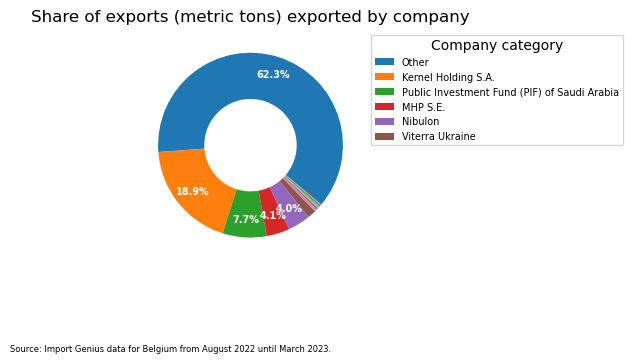

,company_std,weight_ton
0,Other,288866.95172
1,Kernel Holding S.A.,87833.35436
2,Public Investment Fund (PIF) of Saudi Arabia,35593.26400
3,MHP S.E.,18782.77000
4,Nibulon,18411.37500
5,Viterra Ukraine,6874.45000
6,Tavamis Hrup,2041.51000
7,Vesele-Agro LLC,1583.43500
8,Eridon PE,1016.39000
9,NCH Capital Inc.,886.56200


In [5]:
# TODO: Use keyword arguments if it's not obvious what something is - 2, .5 for example
data_source = "Import Genius data for Belgium from August 2022 until March 2023"
min_wedge_percentage=2
min_legend_percentage=0.5

export_shares_all = plot_all_period(ig, data_source, min_wedge_percentage, min_legend_percentage)
export_shares_all

### MONTHLY STACKED BAR CHARTS

We convert the IG dataframe to a wide format so we can plot the monthly stacked bar charts.

In [9]:
# TODO: same note on keyword arguments
# Also, not totally clear what we are doing by passing different columns as arguments
grouping_cols = ["year", "month", "company_std"]
other_cols = ["weight_ton"]
sort_by = ["year", "month", "company_std"]
sort_ascending = True
aggregate_by = {"weight_ton": "sum"}

pivot = create_wide_table(ig, grouping_cols, other_cols, sort_by, sort_ascending, aggregate_by)
pivot

company_std,date,Eridon PE,Karla Marksa 2,Kernel Holding S.A.,MHP S.E.,NCH Capital Inc.,New Agro Podillya LLC,Nibulon,Other,Public Investment Fund (PIF) of Saudi Arabia,Tavamis Hrup,Vesele-Agro LLC,Viterra Ukraine,Vizmir Market
6,9/2022,NaN,55.4,20.0,2896.5,NaN,831.7,NaN,113371.8,6187.7,2041.5,1583.4,6874.4,NaN
1,10/2022,NaN,NaN,NaN,NaN,NaN,NaN,18411.4,17906.4,NaN,NaN,NaN,NaN,NaN
2,11/2022,NaN,NaN,139.1,15886.3,NaN,NaN,NaN,62501.0,17388.8,NaN,NaN,NaN,NaN
3,12/2022,NaN,NaN,39.7,NaN,886.6,NaN,NaN,23673.0,NaN,NaN,NaN,NaN,NaN
0,1/2023,1016.4,NaN,39334.5,NaN,NaN,NaN,NaN,56841.6,12016.7,NaN,NaN,NaN,881.2
4,2/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,289.4,NaN,NaN,NaN,NaN,NaN
5,3/2023,NaN,NaN,48300.0,NaN,NaN,NaN,NaN,14283.8,NaN,NaN,NaN,NaN,NaN


Now we do the same but we estimate the percentages of the wide table

In [10]:
percentages = pivot.copy()
percentages_df = estimate_table_percentages(percentages)
percentages_df

company_std,Eridon PE,Karla Marksa 2,Kernel Holding S.A.,MHP S.E.,NCH Capital Inc.,New Agro Podillya LLC,Nibulon,Other,Public Investment Fund (PIF) of Saudi Arabia,Tavamis Hrup,Vesele-Agro LLC,Viterra Ukraine,Vizmir Market,date
6,0.00,0.04,0.01,2.16,0.0,0.62,0.0,84.69,4.62,1.53,1.18,5.14,0.0,9/2022
1,0.00,0.00,0.00,0.00,0.0,0.00,50.7,49.30,0.00,0.00,0.00,0.00,0.0,10/2022
2,0.00,0.00,0.15,16.56,0.0,0.00,0.0,65.16,18.13,0.00,0.00,0.00,0.0,11/2022
3,0.00,0.00,0.16,0.00,3.6,0.00,0.0,96.23,0.00,0.00,0.00,0.00,0.0,12/2022
0,0.92,0.00,35.73,0.00,0.0,0.00,0.0,51.63,10.92,0.00,0.00,0.00,0.8,1/2023
4,0.00,0.00,0.00,0.00,0.0,0.00,0.0,100.00,0.00,0.00,0.00,0.00,0.0,2/2023
5,0.00,0.00,77.18,0.00,0.0,0.00,0.0,22.82,0.00,0.00,0.00,0.00,0.0,3/2023


Now we plot the stacked bar with our wide format table we created earlier.

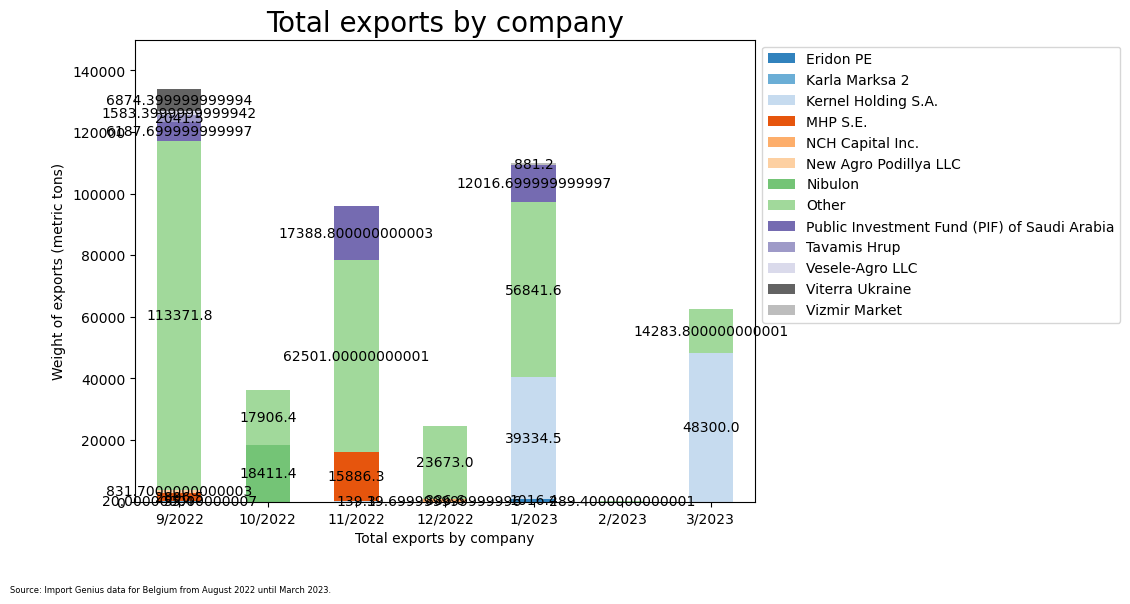

In [12]:
x_title = "Total exports by company"
y_title = "Weight of exports (metric tons)"
plot_title = "Total exports by company"
x_axis_ticks = "date"
y_axis_limit = 150000

plot_stack_bar(pivot, x_title, y_title, plot_title, x_axis_ticks, y_axis_limit, data_source)

Now we do the same but with percentages

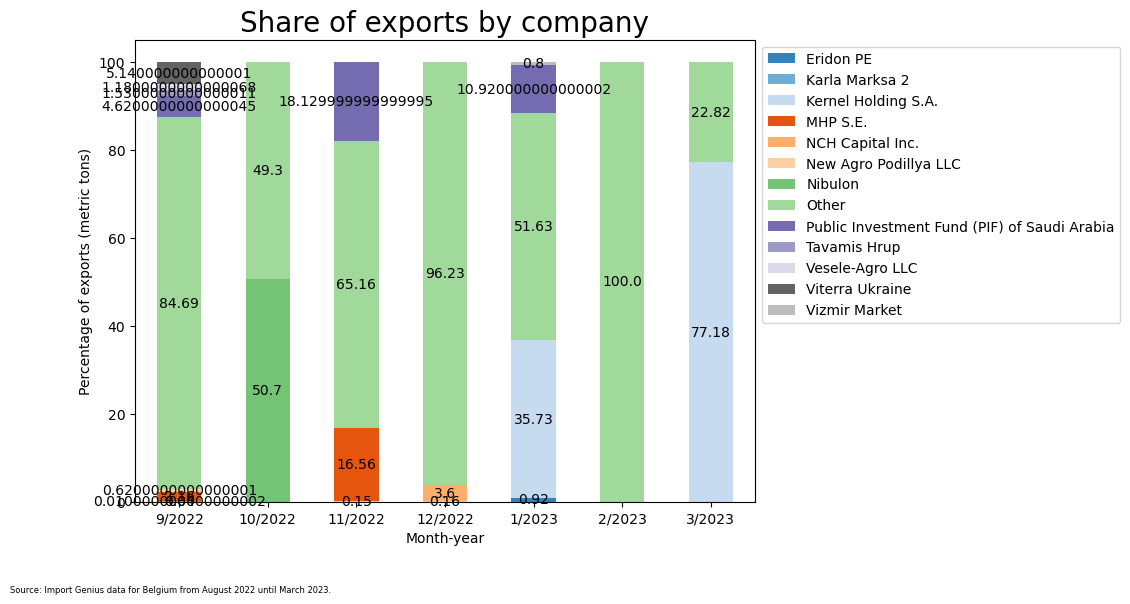

In [13]:
x_title = "Month-year"
y_title = "Percentage of exports (metric tons)"
plot_title = "Share of exports by company"
y_axis_limit = 105

plot_stack_bar(percentages_df, x_title, y_title, plot_title, x_axis_ticks, y_axis_limit, data_source)

## TABLE WITH EXPORTS BY COMPANY (ALL COMPANIES INCLUDED)

Now we get the whole table with all companies exporting to Ukraine to export it and share it with Oakland Institute (OI).

In [14]:
ig["company_all"] = ig["company_std"]
for idx, row in ig.iterrows():
    if row["company_std"] == "Other":
        ig["company_all"][idx] = ig["shipper"][idx]

/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_20447/3077394398.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ig["company_all"][idx] = ig["shipper"][idx]
/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_20447/3077394398.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ig["company_all"][idx] = ig["shipper"][idx]
/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_20447/3077394398.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

We create a new column with the company names translated from Ukrainian to English.

In [18]:
ig_all_comp = cargo_grouping(ig, ["company_all"], ["weight_ton"], ["weight_ton"], True, {"weight_ton": "sum"})
ig_all_comp = ig_all_comp.sort_values(by=["weight_ton"], ascending=[False])
translate_column(ig_all_comp, "company_all", "google", source="uk", target="en") # this step takes awhile

We export the table as a .csv file.

In [19]:
ig_all_comp.to_csv('../data/total_exports_by_company_spain.csv', index=False)
ig_all_comp.head()

,company_all,weight_ton,company_all_gt
8,Archer Daniels Midland,305326.560,Archer Daniels Midland
76,Viterra Ukraine,278390.438,Viterra Ukraine
38,Louis Dreyfus,223059.678,Louis Dreyfus
16,Cargill,111641.562,Cargill
32,Kernel Holding S.A.,95709.952,Kernel Holding S.A.


## EXPLORATORY ANALYSIS FOR MANUAL COMPANY MATCHING

We first get the top n companies exporting to Ukraine.

In [16]:
tempo = cargo_grouping(ig, ["company_all"], ["weight_ton"], ["weight_ton"], True, {"weight_ton": "sum"})
tempo.sort_values(by=["weight_ton"], ascending=False)[:50]

,company_all,weight_ton
2,Kernel Holding S.A.,87833.35436
85,ТОВ АТ КАРГІЛЛ 03150 МІСТО КИЇВ ВУЛ ВЕЛИКА ВАС...,59114.80000
7,Public Investment Fund (PIF) of Saudi Arabia,35593.26400
3,MHP S.E.,18782.77000
6,Nibulon,18411.37500
107,ТОВ ЗЕМЛЯ І ВОЛЯ 17400 ЧЕРНІГІВСЬКА ОБЛ М БОБР...,11583.54600
74,ТОВ АГРОФІРМА СЕМЕРЕНЬКИ 42644 СУМСЬКА ОБЛ ОХТ...,9847.40000
16,ПП АГРАРНА КОМПАНІЯ 2004 31222 ХМЕЛЬНИЦЬКА ОБЛ...,8263.31000
160,ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ АГРОФІ...,8147.78400
121,ТОВ НВФ УРОЖАЙ 19421 ЧЕРКАСЬКА ОБЛ ЧЕРКАСЬКИЙ ...,7555.88000


Then we get the full company name.

In [21]:
tempo.loc[698]["company_all"]

'ТОВ ПРОМІНЬ ПОДІЛЛЯ УКРАЇНА 32625 ХМЕЛЬНИЦЬКА ОБЛ КАМ ЯНЕЦЬ ПОДІЛЬСЬКИЙ Р Н С ПЕСЕЦЬ'

We double check that the company is actually exporting crops to confirm we filtered the IG dataset correctly with companies that only export agricultural products that appear in BSGI.

In [22]:
ig[ig["shipper"] == 'ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ МП НІКО УКРАЇНА 01133 МІСТО КИЇВ БУЛЬВАР ЛЕСІ УКРАЇНКИ БУДИНОК 28 КВАРТИР']["product"]

1447    пшениця і суміш пшениці та жита (меслин): - ін...
Name: product, dtype: object

We check if there are any name matches with the Land Matrix company parents we found
in Land Matrix.

First we get the Land Matrix data.

In [23]:
deals = pd.read_csv("../data/land_matrix/deals.csv", delimiter=";")
deals_c = deals.copy()
deals_c.loc[:, "country_low"] = deals_c.loc[:, "Target country"].str.lower()
deals_c = deals_c.loc[deals_c.loc[:, "country_low"].str.contains("ukraine", na=False)]
deals_c["Target country"]

/var/folders/fp/_kmrwvmj0790xd_yv16gm1t80000gn/T/ipykernel_60910/99570549.py:1: DtypeWarning: Columns (139) have mixed types. Specify dtype option on import or set low_memory=False.
  deals = pd.read_csv("../data/land_matrix/deals.csv", delimiter=";")


572     Ukraine
573     Ukraine
574     Ukraine
575     Ukraine
576     Ukraine
         ...   
6461    Ukraine
6462    Ukraine
6463    Ukraine
6464    Ukraine
6467    Ukraine
Name: Target country, Length: 358, dtype: object

In [24]:
deals_c[deals_c["Top parent companies"].str.lower().str.contains("premium")]["Top parent companies"]

Series([], Name: Top parent companies, dtype: object)

In [25]:
sorted(deals_c["Top parent companies"].unique())

['AGR Invest Holding Ltd#40757#',
 'AGT Capital Management Ltd.#41248#',
 'Agro Ukraina AB#44407#',
 'Agro-Podillya i K LLC#43419#',
 'AgroGeneration#656#',
 'AgroGeneration#656#|Azent Ltd.#40783#',
 'AgroGeneration#656#|L`ost Dominic#41121#|Mandua Catrin#41123#|Claud Mandua#41124#',
 'Agromino A/S#4970#',
 'Agroton Public Limited#38647#',
 'Agrovista Limited#41491#',
 'Akella Impex LP#5042#',
 'Aladin tekstil ve hiyim iuriunleri tidzharet LLC#44904#',
 'Alberto Kazoni#5062#|Kyrylenko Volodymyr#5063#|Vorotyntsev Vitaliy#5064#',
 'Albus Gunter#41907#',
 'Alexander Wolters#41898#',
 'Alpha-Capital LLC#44409#',
 'Aslan Global Management#1779#',
 'BKW Group LLC#43027#',
 'Berend Popke van der Velde#40762#|Herrit Tonkens#40763#|Huzinha Kornelius Hendrick#40764#|Oxana Kryachko#40765#',
 'Berry Farma ApS#5060#',
 'Bitex Trade Ltd.#43046#',
 'Bontrup Holding#4963#',
 'Brunner&Partner LLC#5047#|Glendore Holding LLC#5048#',
 "Brykivs'ke LLC#43422#",
 'CNBM International energy PTE.LTD#44677#',
 

## DIFFERENCE IN EXPORTS BETWEEN IG AND BSGI

We do some analysis to see why we have differences in weights between IG and BSGI

In [26]:
ig_g = cargo_grouping(ig, ["year", "month"], ["weight_ton"], ["year", "month"], True, {"weight_ton": "sum"}).rename(columns={"weight_ton": "IG"})
ig_g["date"] = ig_g["month"].astype(str) + "/" + ig_g["year"].astype(str)
ig_g = ig_g.drop(['year', 'month'], axis=1)
ig_g = ig_g[["date", "IG"]]

bsgi_g = cargo_grouping(bsgi, ["year", "month"], ["weight_ton"], ["year", "month"], True, {"weight_ton": "sum"}).rename(columns={"weight_ton": "BSGI"})
bsgi_g["date"] = bsgi_g["month"].astype(str) + "/" + bsgi_g["year"].astype(str)
bsgi_g = bsgi_g.drop(['year', 'month'], axis=1)
bsgi_g = bsgi_g[["date", "BSGI"]]

final = ig_g.merge(bsgi_g, on="date", suffixes=("_ig", "_bsgi")).round(1)
final

,date,IG,BSGI
0,8/2022,28628.7,151215
1,9/2022,854280.0,969183
2,10/2022,637181.3,677244
3,11/2022,558257.0,447753
4,12/2022,868976.7,656332
5,1/2023,495452.5,466657
6,2/2023,527222.1,516507
7,3/2023,683573.2,636927


Text(-90, -60, 'Source: IG and BSGI exports to India, Vietnam and Sri Lanka from August 2022 until March 2023.')

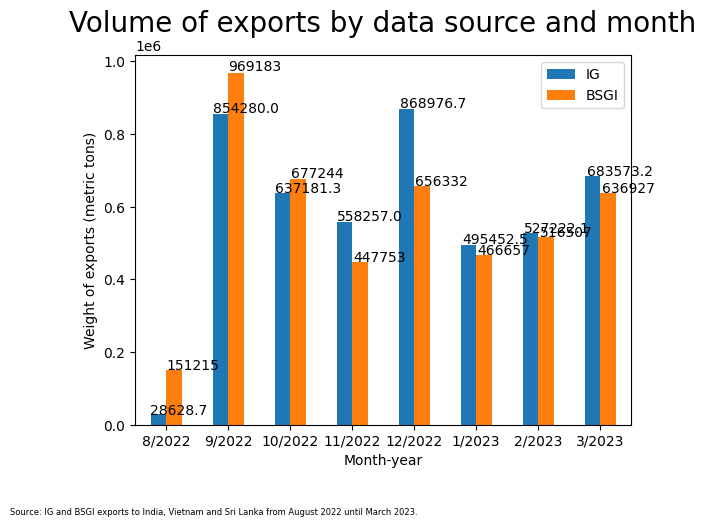

In [27]:
ax = final.plot.bar(rot=0)
ax.set_title("Volume of exports by data source and month", fontsize=20)
ax.set_xticklabels(final["date"], rotation=0)
ax.set_xlabel("Month-year")
ax.set_ylabel("Weight of exports (metric tons)")
for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
ax.annotate(f"Source: IG and BSGI exports to India, Vietnam and Sri Lanka from August 2022 until March 2023.", (0,0), (-90,-60), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points', va='top')